# 分類モデルを構築する: 美味しいアジア料理とインド料理


## 料理分類器 1

このレッスンでは、*材料のグループに基づいて特定の国の料理を予測する*ためのさまざまな分類器を探ります。その過程で、分類タスクにアルゴリズムを活用する方法についてさらに学びます。

### [**事前クイズ**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **準備**

このレッスンは、[前回のレッスン](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb)を基に進めます。前回のレッスンでは以下を行いました：

- アジアとインドの素晴らしい料理に関するデータセットを使って、分類の基本的な紹介を行いました 😋。

- データを準備し、クリーンアップするためにいくつかの[dplyrの動詞](https://dplyr.tidyverse.org/)を探りました。

- ggplot2を使って美しい可視化を作成しました。

- [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html)を使用してデータを前処理し、不均衡なデータに対処する方法を示しました。

- レシピを`prep`して`bake`することで、期待通りに動作することを確認する方法を示しました。

#### **前提条件**

このレッスンでは、データをクリーンアップし、準備し、可視化するために以下のパッケージが必要です：

- `tidyverse`: [tidyverse](https://www.tidyverse.org/)は、データサイエンスをより速く、簡単に、そして楽しくするために設計された[Rパッケージのコレクション](https://www.tidyverse.org/packages)です！

- `tidymodels`: [tidymodels](https://www.tidymodels.org/)フレームワークは、モデリングと機械学習のための[パッケージのコレクション](https://www.tidymodels.org/packages/)です。

- `themis`: [themisパッケージ](https://themis.tidymodels.org/)は、不均衡なデータに対処するための追加のレシピステップを提供します。

- `nnet`: [nnetパッケージ](https://cran.r-project.org/web/packages/nnet/nnet.pdf)は、単一の隠れ層を持つフィードフォワードニューラルネットワークや多項ロジスティック回帰モデルを推定するための関数を提供します。

以下のようにインストールできます：


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

または、以下のスクリプトを使用すると、このモジュールを完了するために必要なパッケージがインストールされているか確認し、足りない場合は自動的にインストールします。


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. データをトレーニングセットとテストセットに分割する

前回のレッスンからいくつかのステップを選んで始めましょう。

### 異なる料理間で混乱を招きやすい、最も一般的な食材を `dplyr::select()` を使って除外する

みんなが大好きな米、ニンニク、そしてショウガ！


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


完璧です！では、データを分割して、70%をトレーニング用データ、30%をテスト用データに振り分けましょう。また、分割時には「ストラティフィケーション」技法を適用して、トレーニングデータセットと検証データセット内で各料理の割合を維持するようにします。

[rsample](https://rsample.tidymodels.org/) は、Tidymodels のパッケージで、効率的なデータ分割やリサンプリングのためのインフラを提供します。


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. 不均衡データへの対処

元のデータセットやトレーニングセットを見て気づいたかもしれませんが、料理の数にはかなりの偏りがあります。韓国料理はタイ料理の*ほぼ*3倍の数です。不均衡なデータは、モデルのパフォーマンスに悪影響を及ぼすことがよくあります。多くのモデルは観測数が均等であるときに最も良いパフォーマンスを発揮するため、不均衡なデータには苦戦しがちです。

不均衡データセットに対処する方法は主に2つあります：

- 少数派クラスに観測値を追加する：`オーバーサンプリング` 例えば、SMOTEアルゴリズムを使用して、少数派クラスの近傍のデータをもとに新しい例を合成的に生成する方法。

- 多数派クラスから観測値を削除する：`アンダーサンプリング`

前回のレッスンでは、`recipe`を使って不均衡データセットに対処する方法を説明しました。`recipe`とは、データ分析の準備をするためにデータセットにどのような手順を適用すべきかを記述した設計図のようなものと考えることができます。今回の場合、`training set`における料理の数を均等に分布させたいと考えています。それでは、さっそく始めましょう。


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

レシピが期待通りに動作することを確認するために（prep + bakeを使用して）、もちろん試してみることができます。すべての料理ラベルに「559」の観測値があることを確認してください。

このレシピをモデリングの前処理として使用する予定なので、`workflow()`を使用すればprepとbakeをすべて自動で行ってくれるため、レシピを手動で推定する必要はありません。

では、モデルのトレーニングを始めましょう 👩‍💻👨‍💻！

## 3. 分類器の選択

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>@allison_horstによるアートワーク</figcaption>


どのアルゴリズムを使用するか決める必要がありますね 🤔。

Tidymodelsでは、[`parsnip パッケージ`](https://parsnip.tidymodels.org/index.html)が、異なるエンジン（パッケージ）間でモデルを扱うための一貫したインターフェースを提供しています。[モデルの種類とエンジン](https://www.tidymodels.org/find/parsnip/#models)や、それに対応する[モデル引数](https://www.tidymodels.org/find/parsnip/#model-args)については、parsnip のドキュメントをご覧ください。最初はその多様性に圧倒されるかもしれません。例えば、以下のような手法が分類技術に含まれます：

-   C5.0 ルールベース分類モデル  
-   柔軟な判別モデル  
-   線形判別モデル  
-   正則化判別モデル  
-   ロジスティック回帰モデル  
-   多項回帰モデル  
-   ナイーブベイズモデル  
-   サポートベクターマシン  
-   最近傍法  
-   決定木  
-   アンサンブル手法  
-   ニューラルネットワーク  

このリストはまだまだ続きます！

### **どの分類器を選ぶべきか？**

では、どの分類器を選べばよいのでしょうか？多くの場合、いくつか試してみて良い結果を探るのが一つの方法です。

> AutoML はこの問題をうまく解決してくれます。クラウド上でこれらの比較を実行し、データに最適なアルゴリズムを選択できるようにしてくれます。[こちら](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)で試してみてください。

また、分類器の選択は問題に依存します。例えば、結果が「2つ以上のクラス」に分類される場合（今回のケースのように）、`多クラス分類アルゴリズム`を使用する必要があります。これは、`二値分類`とは異なります。

### **より良いアプローチ**

しかし、単に当てずっぽうで選ぶよりも、ダウンロード可能な[ML チートシート](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott)のアイデアに従う方が良い方法です。ここでは、今回の多クラス問題に対していくつかの選択肢があることがわかります：

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Microsoft のアルゴリズムチートシートの一部、多クラス分類オプションを詳細に説明</figcaption>


### **理由**

制約を考慮しながら、異なるアプローチを検討してみましょう：

-   **ディープニューラルネットワークは重すぎる**。データセットがクリーンであるものの最小限であり、ノートブックを使ってローカルでトレーニングを行うことを考えると、ディープニューラルネットワークはこのタスクには重すぎます。

-   **2クラス分類器は使用しない**。2クラス分類器は使用しないため、one-vs-allのアプローチは除外されます。

-   **決定木やロジスティック回帰は有効かもしれない**。決定木や多項式回帰、多クラスロジスティック回帰は多クラスデータに対して有効かもしれません。

-   **多クラスブースト決定木は異なる問題を解決する**。多クラスブースト決定木は非パラメトリックなタスク、例えばランキングを構築するタスクに最適であり、今回の目的には適していません。

また、通常はアンサンブル法などの複雑な機械学習モデルに取り組む前に、最もシンプルなモデルを構築してデータの状況を把握するのが良い方法です。したがって、このレッスンではまず`多項式回帰`モデルから始めます。

> ロジスティック回帰は、結果変数がカテゴリカル（または名義尺度）の場合に使用される手法です。バイナリロジスティック回帰では結果変数が2つですが、多項式ロジスティック回帰では結果変数が2つ以上になります。詳細については[高度な回帰手法](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html)をご覧ください。

## 4. 多項式ロジスティック回帰モデルのトレーニングと評価

Tidymodelsでは、`parsnip::multinom_reg()`を使用して、多項式分布を用いて多クラスデータを予測する線形予測モデルを定義します。`?multinom_reg()`を参照すると、このモデルをフィットするために使用できるさまざまな方法やエンジンについて確認できます。

この例では、デフォルトの[nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf)エンジンを使用して多項式回帰モデルをフィットします。

> `penalty`の値はほぼランダムに選びました。この値を選ぶより良い方法としては、`リサンプリング`を使用し、モデルを`チューニング`する方法がありますが、これについては後ほど説明します。
>
> モデルのハイパーパラメータをチューニングする方法について学びたい場合は、[Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/)をご覧ください。


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


素晴らしい仕事です 🥳！これでレシピとモデル仕様が揃ったので、それらを一つのオブジェクトにまとめる方法を見つける必要があります。このオブジェクトは、まずデータを前処理し、その後前処理済みデータにモデルを適合させ、さらに必要に応じて後処理を行うことも可能にします。Tidymodelsでは、この便利なオブジェクトを[`workflow`](https://workflows.tidymodels.org/)と呼び、モデリングの構成要素を便利に保持します！これは、*Python*で言うところの*パイプライン*に相当します。

それでは、すべてをワークフローにまとめましょう！📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


ワークフロー 👌👌! **`workflow()`** はモデルとほぼ同じ方法で適合させることができます。では、モデルをトレーニングする時間です！


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

モデルが学習中に得た係数が出力されます。

### 学習済みモデルの評価

テストセットでモデルの性能を評価する時が来ました 📏！まずはテストセットに対して予測を行いましょう。


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


素晴らしい仕事です！Tidymodelsでは、モデルの性能評価は[yardstick](https://yardstick.tidymodels.org/)を使用して行うことができます。これは、性能指標を使用してモデルの有効性を測定するためのパッケージです。ロジスティック回帰のレッスンで行ったように、まず混同行列を計算することから始めましょう。


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

複数のクラスを扱う場合、これをヒートマップのように視覚化する方が一般的に直感的です。このように:


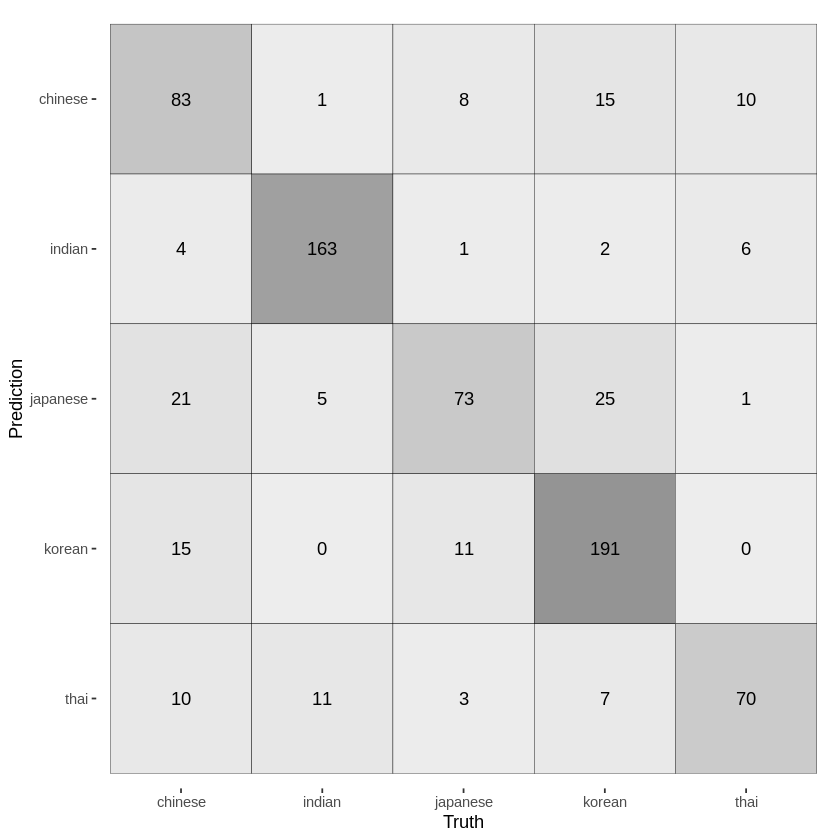

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

混同行列プロットの中で、濃い色の四角は多くのケースを示しており、予測ラベルと実際のラベルが一致しているケースを示す濃い色の四角が対角線上にあることが確認できるはずです。

次に、混同行列の要約統計量を計算してみましょう。


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


もし、精度、感度、PPVといったいくつかの指標に絞って考えるなら、スタートとしては悪くないですね 🥳！

## 4. さらに深掘り

ここで一つ微妙な質問をしてみましょう：あるタイプの料理を予測結果として選ぶ基準は何でしょうか？

実は、ロジスティック回帰のような統計的機械学習アルゴリズムは、`確率`に基づいています。つまり、分類器が実際に予測しているのは、可能性のある結果の集合に対する確率分布です。そして、最も高い確率を持つクラスが、与えられた観測データに対して最も可能性の高い結果として選ばれます。

これを実際に確認するために、ハードなクラス予測と確率の両方を試してみましょう。


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


もっと良くなりました！

✅ なぜモデルが最初の観察がタイ料理だと確信しているのか説明できますか？

## **🚀チャレンジ**

このレッスンでは、クリーンアップしたデータを使用して、材料の組み合わせに基づいて国の料理を予測する機械学習モデルを構築しました。Tidymodelsが提供する[多くのオプション](https://www.tidymodels.org/find/parsnip/#models)を読んでデータを分類する方法や、[他の方法](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models)で多項ロジスティック回帰を適合させる方法を確認してください。

#### 感謝の言葉：

[`Allison Horst`](https://twitter.com/allison_horst/) さん、Rをより親しみやすく魅力的にする素晴らしいイラストを作成してくださりありがとうございます。彼女の[ギャラリー](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM)でさらに多くのイラストをご覧ください。

[Cassie Breviu](https://www.twitter.com/cassieview) さんと [Jen Looper](https://www.twitter.com/jenlooper) さん、モジュールの元となるPython版を作成してくださりありがとうございます ♥️

<br>
食べ物のダジャレは理解できないので、ジョークを入れるのはやめておきます 😅。

<br>

楽しい学びを！

[Eric](https://twitter.com/ericntay)、Gold Microsoft Learn Student Ambassador



---

**免責事項**:  
この文書は、AI翻訳サービス [Co-op Translator](https://github.com/Azure/co-op-translator) を使用して翻訳されています。正確性を追求しておりますが、自動翻訳には誤りや不正確な部分が含まれる可能性があります。元の言語で記載された原文が正式な情報源と見なされるべきです。重要な情報については、専門の人間による翻訳を推奨します。本翻訳の利用に起因する誤解や誤認について、当社は一切の責任を負いません。
